In [1]:
import torch
import os
import numpy as np
from torch.utils import data
from torch.nn import DataParallel
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel, AutoModelForCausalLM, BertConfig, BertForPreTraining, BertForMaskedLM, AutoConfig, AutoModelForSequenceClassification
import transformers
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import scipy
import json
import tqdm
import sys
import pyfaidx
sys.path.append("../src/regulatory_lm/")
from evals.nucleotide_dependency import *
from modeling.model import *
from utils.viz_sequence import *

/users/patelas/anaconda3/envs/LanguageModelingEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_str_dict = MODULES
FLOAT_DTYPES = {"float32":torch.float32, "float64":torch.float64, "bfloat16":torch.bfloat16, "float16":torch.float16}


In [3]:
MAPPING = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    
def encode_sequence(sequence): 
    encoded_sequence = [MAPPING.get(nucleotide, 4) for nucleotide in sequence]
    return encoded_sequence

def revcomp(seq_list):
    return [3-x for x in seq_list][::-1]

def revcomp_string(dna_sequence):
    complement = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
    return ''.join(complement[base] for base in reversed(dna_sequence.upper()))


In [16]:
genome = "/oak/stanford/groups/akundaje/patelas/regulatory_lm/data/hg38_repeat_lowercase.fa"
genome_data = pyfaidx.Fasta(genome, sequence_always_upper=True)
chrom = "chr3"#"chr3"#"chrX"#""chr11"#chr19#"chr18"
seq_len = 350
start = 4868352#4868352##24693801#5280547#52189687#26928016
end = 4868665#4868665##24693921#5280890#52190037#26928040
midpoint = (start + end) // 2
start = midpoint - seq_len // 2
end = midpoint + seq_len // 2
print(midpoint, start, end)
dna_seq = genome_data[chrom][start:end].seq
seq_tensor = torch.tensor(encode_sequence(dna_seq))


4868508 4868333 4868683


# HyenaDNA

In [17]:
model_name = f"LongSafari/hyenadna-large-1m-seqlen-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, padding_side="right")
model =  AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

In [18]:
seq_tensor = tokenizer([dna_seq], return_tensors = 'pt')["input_ids"]

In [19]:
def plot_scores(scores, demarcs=[], limits=None):
    plt.figure(dpi=300, figsize=[16,8])
    plot_weights(scores)
    plt.xticks([])
    max_val = np.abs(scores).max()
    if max_val < 0.05:
        plt.ylim(-0.05, 0.05)
    for motif in demarcs:
        plt.axvline(motif[0], color="black")
        plt.axvline(motif[1], color="black")
    if limits is not None:
        plt.ylim(limits[0], limits[1])
#     plt.savefig("/users/patelas/scratch/betaglobin.svg")
    plt.show()

In [20]:
def predict(seq, mask_inds, model, tokenizer, demarcs=[], limits=None):
    one_hot = torch.zeros(1, len(seq), 4, dtype=torch.int8)
    seq_encoded_true = encode_sequence(seq)
    seq_tensor_true = torch.tensor(seq_encoded_true)
    for nuc in range(4):
        one_hot[:,:,nuc] = (seq_tensor_true == nuc).to(dtype=torch.int8) # for non ACGT, set to 0
    one_hot = one_hot.cpu().numpy(force=True).transpose([0,2,1])
    seq_tensor = tokenizer([seq], return_tensors = 'pt')["input_ids"]
    softmax = torch.nn.Softmax(dim=-1)
    with torch.no_grad():
        seq_tensor = seq_tensor.to(device)
        model = model.to(device)
        logits = model(seq_tensor).logits
        probs_norm = softmax(logits)[:,:-1,7:11]
    nuc_average = torch.mean(probs_norm, dim=1)
    print(probs_norm[:,174,:])
    probs_norm = (probs_norm * torch.log(probs_norm / nuc_average)).permute(0,2,1).cpu().numpy()
    print(probs_norm.shape)
    plot_scores(probs_norm[:,:,min(mask_inds):max(mask_inds) + 1] * one_hot[:,:,min(mask_inds):max(mask_inds) + 1], demarcs, limits)
    plot_scores(probs_norm[:,:,min(mask_inds):max(mask_inds) + 1], demarcs, limits)
    return probs_norm * one_hot

tensor([[0.1013, 0.4027, 0.3236, 0.1724]], device='cuda:0')
(1, 4, 350)


<Figure size 4800x2400 with 0 Axes>

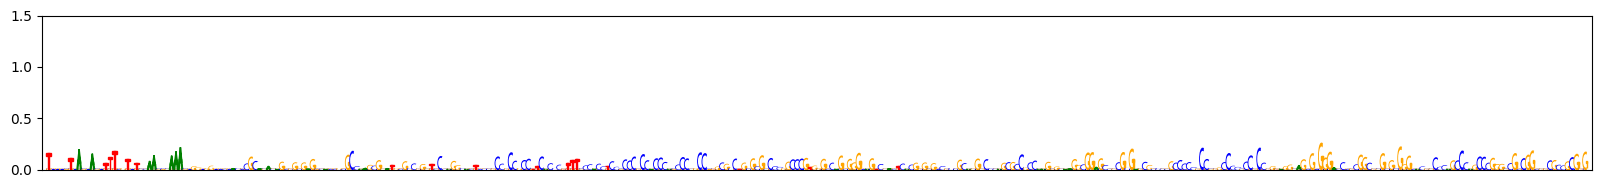

<Figure size 4800x2400 with 0 Axes>

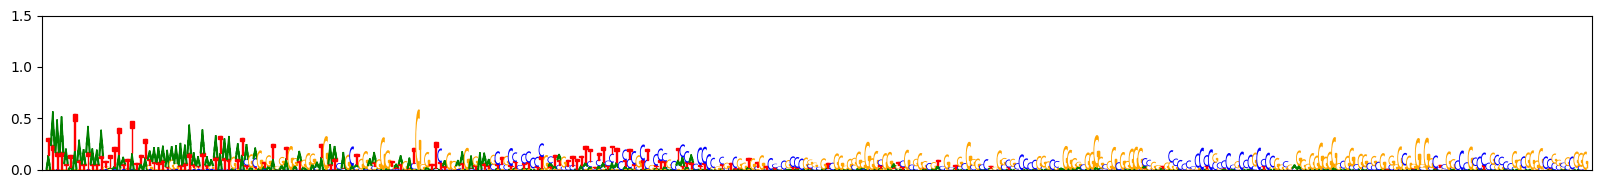

In [21]:
probs_norm = predict(dna_seq, list(range(0, 350)), model, tokenizer, limits=[0,1.5])

# Caduceus

In [22]:
model_name = f"kuleshov-group/caduceus-ps_seqlen-131k_d_model-256_n_layer-16"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, padding_side="right")
model = AutoModelForMaskedLM.from_pretrained(model_name, trust_remote_code=True)


In [23]:
seq_tensor = tokenizer([dna_seq], return_tensors = 'pt')["input_ids"]

In [24]:
def plot_scores(scores, demarcs=[], limits=None):
    plt.figure(dpi=300, figsize=[16,8])
    plot_weights(scores)
    plt.xticks([])
    max_val = np.abs(scores).max()
    if max_val < 0.05:
        plt.ylim(-0.05, 0.05)
    for motif in demarcs:
        plt.axvline(motif[0], color="black")
        plt.axvline(motif[1], color="black")
    if limits is not None:
        plt.ylim(limits[0], limits[1])
#     plt.savefig("/users/patelas/scratch/betaglobin.svg")
    plt.show()

In [25]:
def predict(seq, mask_inds, model, tokenizer, demarcs=[], limits=None):
    new_probs = []
    one_hot = torch.zeros(1, len(seq), 4, dtype=torch.int8)
    seq_encoded_true = encode_sequence(seq)
    seq_tensor_true = torch.tensor(seq_encoded_true)
    for nuc in range(4):
        one_hot[:,:,nuc] = (seq_tensor_true == nuc).to(dtype=torch.int8) # for non ACGT, set to 0
    one_hot = one_hot.cpu().numpy(force=True).transpose([0,2,1])
    softmax = torch.nn.Softmax(dim=-1)
    for ind in mask_inds:
        seq_tensor = tokenizer([seq], return_tensors = 'pt')["input_ids"]
        seq_tensor[:,ind] = 3
        with torch.no_grad():
            model.eval()
            model = model.to(device)
            logits = model(seq_tensor.to(device)).logits
            probs = F.softmax(logits, dim=-1)[:,:-1,7:11]
            probs_norm = probs.cpu().permute(0,2,1)
            new_probs.append(probs_norm[:,:,ind])
    for i, ind in enumerate(mask_inds):
        probs_norm[:,:,ind] = new_probs[i]
    probs_norm = probs_norm.permute(0,2,1)
    print(probs_norm.shape)
    nuc_average = torch.mean(probs_norm, dim=1)
#     print(probs_norm[:,174,:])
    probs_norm = (probs_norm * torch.log(probs_norm / nuc_average)).permute(0,2,1).cpu().numpy()
#     probs_norm = probs_norm.numpy() - 0.25
#     entropy_metric = 2 + (probs_norm * np.log2(probs_norm)).sum(1)
#     probs_norm = entropy_metric * probs_norm
    print(probs_norm.shape)
    plot_scores(probs_norm[:,:,min(mask_inds):max(mask_inds) + 1] * one_hot[:,:,min(mask_inds):max(mask_inds) + 1], demarcs, limits)
    plot_scores(probs_norm[:,:,min(mask_inds):max(mask_inds) + 1], demarcs, limits)
    return probs_norm * one_hot

torch.Size([1, 350, 4])
(1, 4, 350)


<Figure size 4800x2400 with 0 Axes>

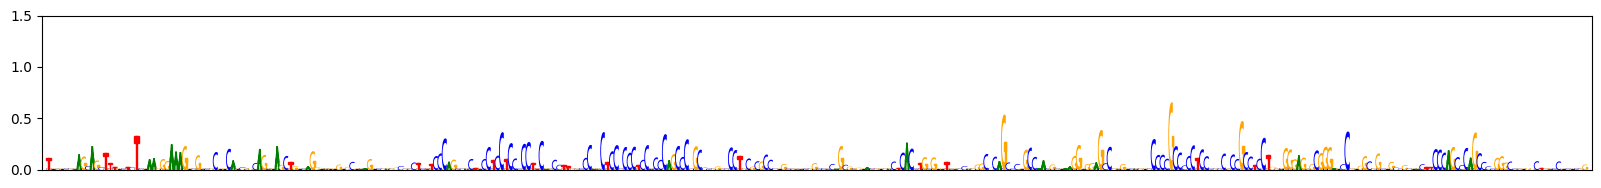

<Figure size 4800x2400 with 0 Axes>

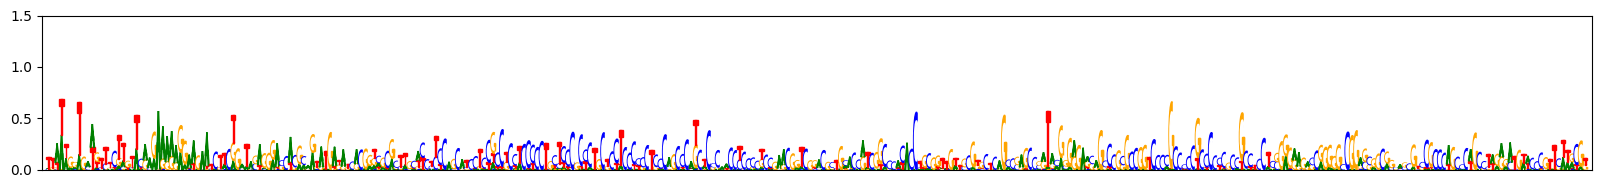

In [27]:
probs_norm = predict(dna_seq, list(range(0, 350)), model, tokenizer, limits=[0,1.5])